In [134]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=[18, 11]

In [135]:
#Create empty class of formulas A2.*
class formulas_A2:
    pass
A2=formulas_A2()# Создаем абсолютно пусто Инстанс (экземпляр) 'A2'

# 1: Calculation of the elastic compliance from ASTM1820 (A2.10 and A2.11)

<img src="photo_2018-10-31_16-04-39.jpg" height="420" width="420"  />

$$
C_{LL(i)}= {\frac 1{E\cdot B_e}}\left(\frac {W+a_i}{W-a_i}\right)^2
\left[
2.1630+12.219\left(\frac {a_i}W\right)
-20.065\left(\frac {a_i}W\right)^2
-0.9925\left(\frac {a_i}W\right)^3
+20.609\left(\frac {a_i}W\right)^4
-9.9314\left(\frac {a_i}W\right)^5
\right]
\qquad(A2.10) 
\\
\\
\boldsymbol{where:} \\
B_e = B-\frac{(B-B_N)^2}B \;mm
\qquad\qquad\qquad\qquad\qquad\qquad(A2.11)
\\
\\
$$
___
$$
B = 20 \;mm \\
B_N = 0.2 \cdot\;B \\
E = 190 000 \;MPa = 190 000 \;\frac N {{mm}^2} \\
W = 40\;mm \\
$$

In [136]:
#Вводим в оборот формулы А2.10 и А2.11
def __(self, ai): #(A2.10)
    #вводим константы для (A2.10)
    self.B= 20.
    self.BN= 0.2*self.B
    self.Be= self.B - (self.B-self.BN)**2/self.B # (A2.11)
    self.E= 190000.
    self.W= 40.
    
    self.ai=ai #?
    ai_w=ai/self.W
    return (2.1630 + 12.219*ai_w - 20.065*ai_w**2 - 0.9925*ai_w**3 + 20.609*ai_w**4 - 9.9314*ai_w**5) * \
        ( (self.W+ai)/(self.W-ai) )**2./(self.E*self.Be)
    #

formulas_A2._10 = __      # добавляем метод в Класс 'formulas_A2'
A2._10(0.151550581328749) # Юзаем метод для уже существующего Инстанса(экземпляра) 'A2' (test)

1.6394295248661302e-06

In [137]:
#Вводим в оборот метод чтения данных и строим интерполяторы
def __(self):
    self.force = np.loadtxt("FORCE_CMOD_calc1.dat", dtype=np.float)
    self.force[:,1]*=2.0
    self.force[:,2]*=2.0
    self.force_interp = interp1d(self.force[:,1],self.force[:,2], bounds_error=False)

    #загружаем, редуцируем и модифицируем "crack-length_calc1.dat"
    crk=[]
    for xx in np.loadtxt("crack-length_calc1.dat", dtype=np.float):
        if xx[1]:
            crk.append([xx[1], self._10(xx[1]+24.)])
    self.crack=np.asarray(crk)

    #интерполяторы редуцированного массива crack
    self.crack_interp = interp1d(self.crack[:,0],self.crack[:,1], bounds_error=False)
    self.crack_cmode_interp = interp1d(self.crack[:,0], self.force[:,1][- len(self.crack): ], bounds_error=False)
    #
formulas_A2.read=__ #добавляем метод в Класс 'formulas_A2'
A2.read() # Юзаем метод для уже существующего Инстанса(экземпляра) 'A2'

# 1a: creation of the plot $\vartriangle$ a vs. calculated compliance (Cc)

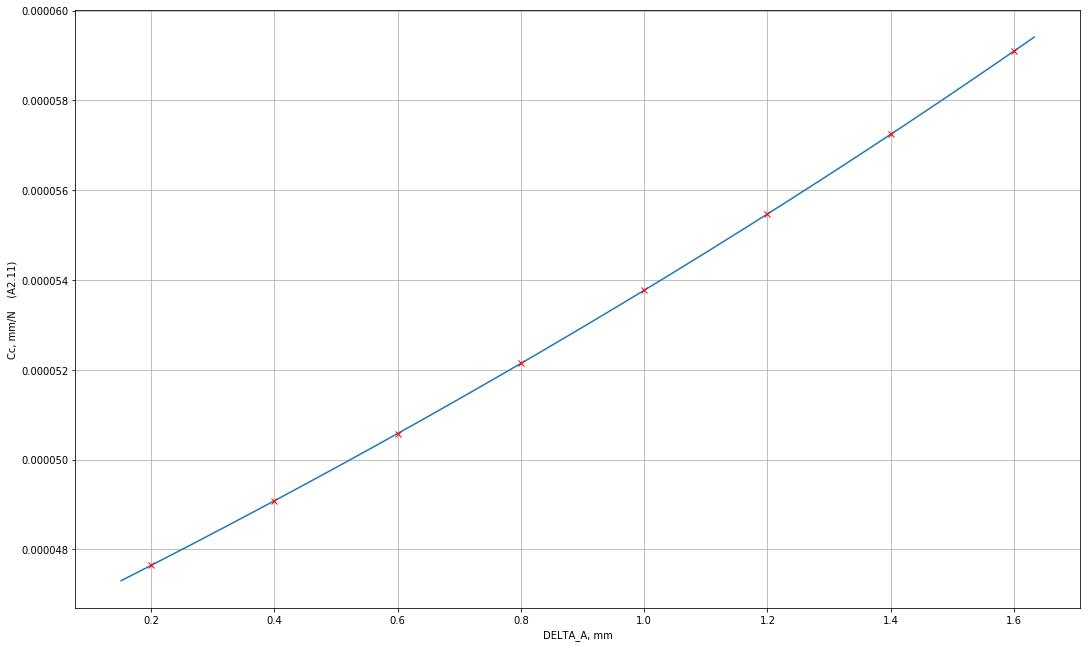

In [138]:
##TEST
# сплошная линия построена по данным массива A2.crack
# контрольные точки построены через функцию-интерполятор массива

plt.rcParams["figure.figsize"]=[18, 11]
plt.plot(A2.crack[:,0],A2.crack[:,1])
plt.xlabel('DELTA_A, mm')
plt.ylabel('Cc, mm/N    (A2.11)')
for _ in [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
    plt.plot(_, A2.crack_interp(_), 'rx')
plt.grid()
plt.show()

# 1b: creation of the plot F vs. CMOD from Code_Aster simulation

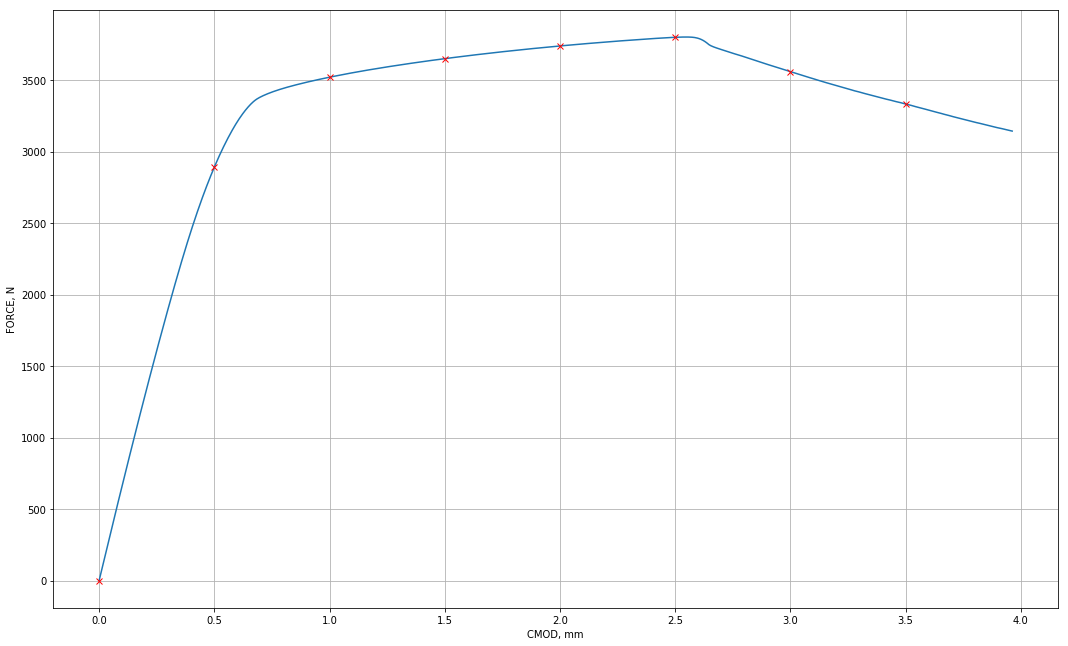

In [139]:
##TEST
# сплошная линия построена по данным массива A2.force
# контрольные точки построены через функцию-интерполятор массива
plt.plot(A2.force[:,1], A2.force[:,2])
plt.xlabel('CMOD, mm')
plt.ylabel('FORCE, N')

for _ in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
    plt.plot(_, A2.force_interp(_), 'rx') # second point
plt.grid()
plt.show()

# 1c: creation of the plot CMOD vs. $\vartriangle$ a 

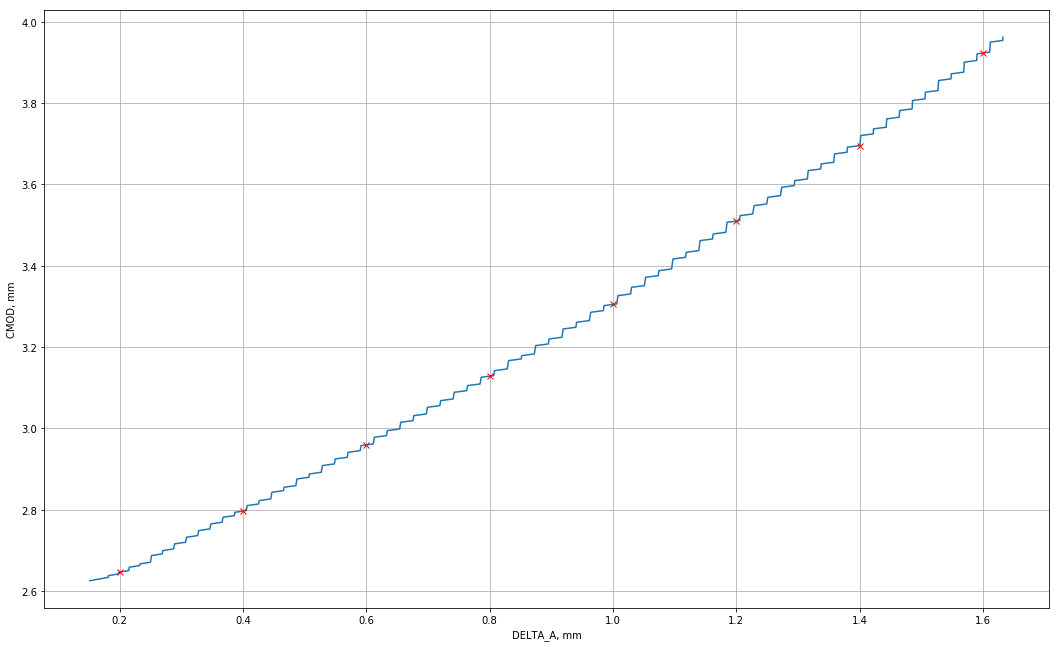

In [140]:
##TEST
plt.plot(A2.crack[:,0], A2.force[:,1][-len(A2.crack) : ])
plt.xlabel('DELTA_A, mm')
plt.ylabel('CMOD, mm')
for _ in [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
    plt.plot(_, A2.crack_cmode_interp(_), 'rx') # second point

plt.grid()
plt.show()

In [159]:
def __(self, delta, eps):
    cc_ = 1./self.crack_interp(delta).item()
    cmode_ = self.crack_cmode_interp(delta).item()
    self.delta=delta

    x1_ = cmode_
    x2_ = self.force[:,1][-1]
    while True:
        y2_ = (x2_ - cmode_) * cc_ 
        f2_ = A2.force_interp(x2_).item()
        #print "x1=%r x2=%r y2=%r f2=%r (y-f)=%r" % (x1_, x2_, y2_, f2_, y2_ - f2_)
        if (abs(y2_-f2_) / f2_) < eps: break
        if y2_ > f2_:
            dx_ = 0.5 * (x2_ - x1_)
            x2_= x1_ + dx_
        if y2_ < f2_:
            x1_ = x2_
            dx_ = dx_ * 0.5
            x2_= x1_ + dx_
        y2_ = (x2_ - cmode_) * cc_ 
        f2_ = self.force_interp(x2_).item()

    from scipy.integrate import quad
    self.apl = quad(self.force_interp, self.force[:,1][0], x2_)[0] - y2_ * (x2_ - cmode_) * 0.5
    self.P = y2_

    return (cmode_, x2_, y2_)
    #
formulas_A2.Apl=__  # добавляем метод 'Apl' в class 'formulas_A2'
A2.Apl(1.0, 0.00001), A2.P, A2.apl # юзаем метод 'Apl' в объекте 'A2' (test)

((3.3049594741390784, 3.4844954046604335, 3338.9810489846254),
 3338.9810489846254,
 11197.801334650865)

# 1d: creation of the intersection of calculated compliance (Cc) with Force-CMOD curvea and calculation of the Apl

In [150]:
##TEST plt()
plt.plot(A2.force[:,1], A2.force[:,2])
A_= A2.Apl(1.0, 0.00001)

plt.plot(A_[0], 0.0, 'ro') # first point
plt.plot(A_[1], A_[2], 'ro') # second point
plt.plot([A_[0],A_[1]], [0.0, A_[2]], 'ro-')
"""
"""

plt.xlabel('CMOD, mm')
plt.ylabel('FORCE, N')
plt.grid()
plt.rcParams["figure.figsize"]=[18, 11]
plt.show()
A_

(3.3049594741390784, 3.4844954046604335, 3338.9810489846254)

# 2a: Calculation of the Jpl according to the ASTM1820 (basic method)

$$
J_{pl(i)}= 
\frac{\eta_{pl} A_{pl}}{B_N b_0}
\qquad(A2.6) 
\\
\boldsymbol{where:} \\
\eta_{pl}=2+0.522\frac{b_{0}}{W}\\
A_{pl} \Longrightarrow 1d \\
b_0=W-a_0 \\
\\
\\
a_0=24 +\vartriangle a \\
B = 20 \;mm \\
B_N = 0.2 \cdot\;B \\
W = 40\;mm \\
$$ 

In [155]:
def __(self): #(A2.6)
    b_0=self.W-self.delta-24.
    self.jpl= (2.+0.522*b_0/self.W)*self.apl/(self.BN*b_0)
    pass
    #
formulas_A2.Jpl = __       # добавляем метод в class 'formulas_A2'
A2.Jpl(0.151550581328749), A2.jpl  # юзаем метод в объекте 'A2' (test)

(None, 177.03768335448717)

# 2b: Calculation of the Jpl according to the ASTM1820 (incremental version)

$$
J_{pl(i)}= \left[
J_{pl(i-1)}+
\left(
\frac{\eta_{pl(i-1)}}
{b_{(i-1)}}
\right)
{\frac {A_{pl(i)}-A_{pl(i-1)}}{B_N}}
\right]
\left[
1-\gamma_{(i-1)} 
\left(
\frac{a_{(i)}-a_{(i-1)}}{b_{(i-1)}}
\right)
\right] \qquad(A2.8) 
\\
\boldsymbol{where:} \\
\eta_{pl(i-1)}=2+0.522\frac{b_{(i-1)}}{W}
\\
\gamma_{(i-1)}=1.0+0.76\frac{b_{(i-1)}}{W}
A_{pl} \Longrightarrow 1d \\
b_{(i-1)}=W-a_{(i-1)} \\
$$

$$
B = 20 \;mm \\
B_N = 0.2 \cdot\;B \\
W = 40\;mm \\
a_i=24 +\vartriangle a
$$ 

# 3: Calculation of the Jel according to the ASTM1820


$$
J_{el}= {\frac {K^2 (1-\nu^2)}{E}} \qquad(A2.4)
\\
\boldsymbol{where:} \\
\\
K_i= {\frac {P_i}{(B B_N W)^{1/2}}}f \left(\frac {a_i}W\right) \qquad(A2.2) 
\\
f\left(\frac {a_i}W\right) = \frac {\left(2+\frac {a_i}W \right)
\left[0.886 + 4.64 \left(\frac {a_i}W \right)-13.32\left(\frac {a_i}W \right)^2 + 14.72\left(\frac {a_i}W \right)^3-5.6\left(\frac {a_i}W \right)^4
\right]
}{\left(1-\frac {a_i}W \right)^{3/2}} \qquad(A2.3) \\
E=190 000 MPa
$$ 


In [171]:
def __(self):
    self.nu = 0.3
    ai_w=(self.delta+24)/self.W
    fi= ((2.0+ai_w)*(0.886 + 4.64*ai_w - 13.32*ai_w**2 + 14.72*ai_w**3 - 5.6*ai_w**4)) * (1-ai_w)**1.5
    Ki= (self.P * fi /self.B*self.BN*self.W)**0.5
    self.jel= Ki*Ki*(1-self.nu**2)/self.E
    #
formulas_A2.Jel = __

A2.Jel(), A2.jel

(None, 0.1019630987169434)

# 4: Calculation of the total energy J

$$
J_{total} = J_{pl}+J_{el}
\qquad(A2.5)
$$


In [172]:
def __(self):
    self.total= self.jpl + self.jel
formulas_A2.Jtotal = __

A2.Jtotal()
A2.jpl, A2.jel, A2.total    

(177.03768335448717, 0.1019630987169434, 177.1396464532041)

   # 5: Creation of the J-R curve

<img src="J_R_curve.png" height="420" width="420"  />

on the J-R curve we plot:

y: $$J_{total}$$
x: $$ \vartriangle a $$